In [1]:
!wget --no-check-certificate \
    https://github.com/fachris007/Tubes-Ai/raw/main/Dataset.zip \
    -O /tmp/Dataset.zip


--2021-12-30 22:43:15--  https://github.com/fachris007/Tubes-Ai/raw/main/Dataset.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fachris007/Tubes-Ai/main/Dataset.zip [following]
--2021-12-30 22:43:16--  https://raw.githubusercontent.com/fachris007/Tubes-Ai/main/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21191783 (20M) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>]  20.21M   130MB/s    in 0.2s    

2021-12-30 22:43:18 (130 MB/s) - ‘/tmp/Dataset.zip’ saved [21191783/21191783]



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/Dataset'
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')

In [5]:
female_train_path = train_dir + '/female'
female_val_path = val_dir + '/female'

male_train_path = train_dir + '/male'
male_val_path = val_dir + '/male'

female_len_train = len(os.listdir(female_train_path))
female_len_val = len(os.listdir(female_val_path))
male_len_train = len(os.listdir(male_train_path))
male_len_val = len(os.listdir(male_val_path))

print("jumlah dataset Training : ", female_len_train + male_len_train)
print("jumlah dataset validasi : ", female_len_val + male_len_val)
print("\n\n")
print("jumlah train kelas female : ", female_len_train)
print("jumlah train kelas male : ", male_len_train)
print("jumlah validasi kelas female : ", female_len_val)
print("jumlah validasi kelas male : ", male_len_val)

jumlah dataset Training :  4000
jumlah dataset validasi :  400



jumlah train kelas female :  2000
jumlah train kelas male :  2000
jumlah validasi kelas female :  200
jumlah validasi kelas male :  200


In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Augmentasi Dataset**

In [7]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# **Augmentasi Model dan Fit Model**

In [8]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [10]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

In [12]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [13]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [15]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch = 100,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps = 10,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7010
Epoch 00001: val_accuracy improved from -inf to 0.77500, saving model to /content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5
100/100 [==============================] - 52s 369ms/step - loss: 0.6665 - accuracy: 0.7010 - val_loss: 0.4826 - val_accuracy: 0.7750
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.7660
Epoch 00002: val_accuracy improved from 0.77500 to 0.82500, saving model to /content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5
100/100 [==============================] - 35s 353ms/step - loss: 0.5308 - accuracy: 0.7660 - val_loss: 0.3621 - val_accuracy: 0.8250
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.7820
Epoch 00003: val_accuracy improved from 0.82500 to 0.87500, saving model to /c

# **Model Evaluasi**

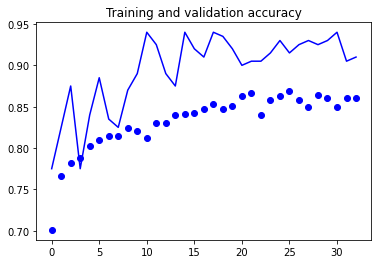

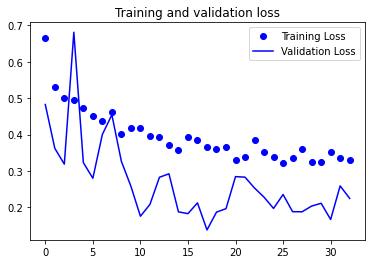

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [19]:
# loading model to evaluate more depth
from keras.models import load_model
model_path = '/content/gdrive/MyDrive/Colab Notebooks/Tubes/Transfer Learning/model_drop_batch_weight_from_callback_2.h5'
model = load_model(model_path)

Found 400 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 0.9275
Precision : 0.9275962091470581
f1Score : 0.9274959216455926
[[187  13]
 [ 16 184]]


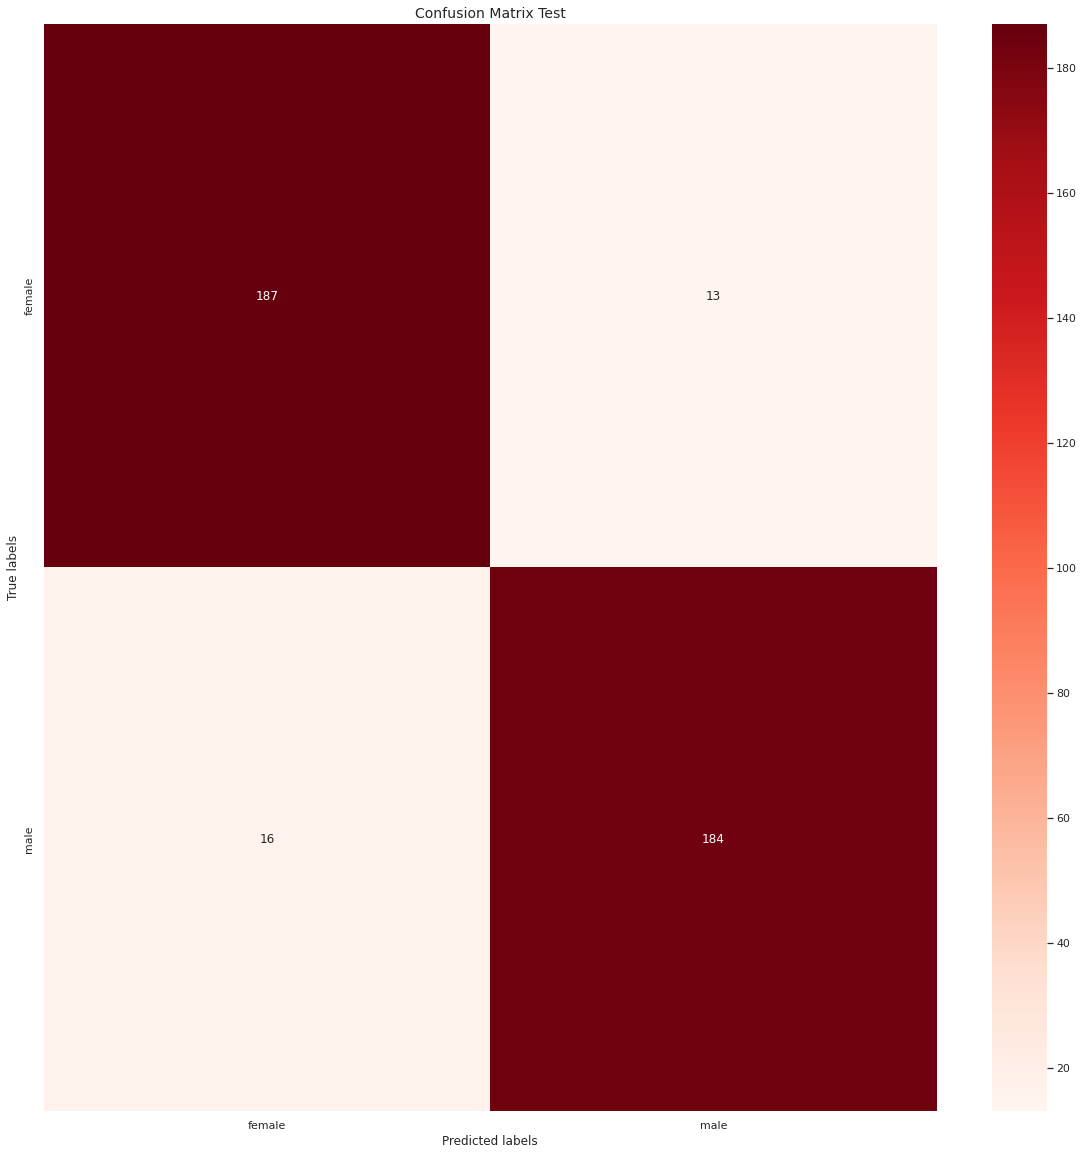

In [23]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = val_dir

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

      female       0.92      0.94      0.93       200
        male       0.93      0.92      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400

